# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [2]:
#импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#вывод всех столбцов
pd.set_option('display.max_columns', None)

In [5]:
#сохраняем данные в переменную, разделитель табуляция
data = pd.read_csv('./datasets/real_estate_data.csv', sep='\t')

#выводим на экран первые 5 строчек датасета
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [4]:
#вывод общей информации о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Данные состоят из 22 колонок и 23699 строк. 

В части колонок есть пропуски данных, колонку "cityCenters_nearest" нужно будет переименовать, чтобы название все было с маленьких букв.

Колонки нужно будет изучить детальнее и, при необходимости, изменить тип данных.

Теперь построим гистограммы по всем числовым колонкам датафрейма.

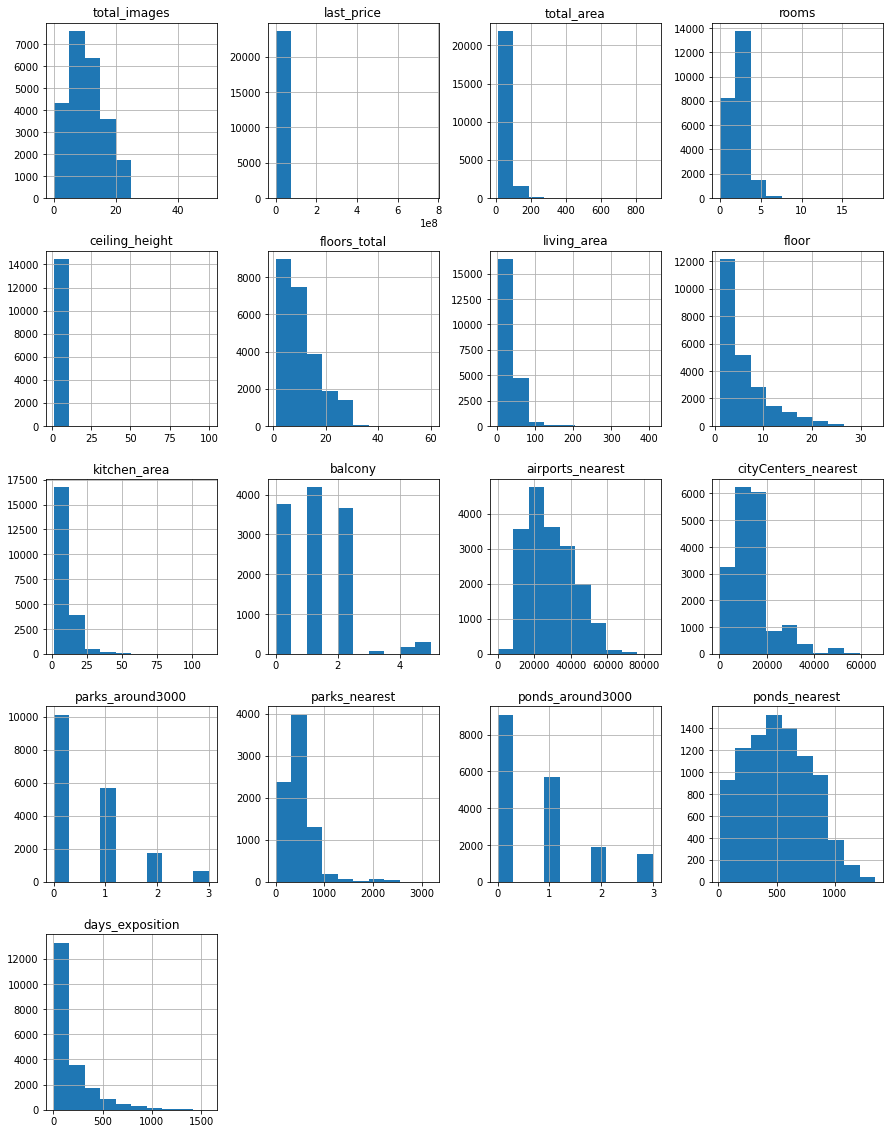

In [5]:
data.hist(figsize=(15, 20));

По размеру оси Х видно, что в ряде колонок (почти во всех) есть определенное количество выбросов больших значений, за счет этих выбросов меняется масштаб графика, и форма гистограмм напоминает не нормальное распределение, а вертикальные столбцы, смещенные влево, туда, где больше всего значений.

Необходимо ниже изучить данные в каждом столбце, убрать/заменить пропуски, определить причины выбросов, устранить возможные ошибки в данных, а также исключить аномальные значения.

### Предобработка данных

#### Обработка пропусков

In [6]:
#переименовываем столбец
data = data.rename(columns={'cityCenters_nearest':'city_centers_nearest'})

In [7]:
#определяем количество пропусков в каждом столбце
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Далее по каждому столбцу с пропусками изучим данные подробнее, заменим пропуски, где это возможно

***Изучим высоту потолков. Построим диаграмму ящик с усами***

<AxesSubplot:>

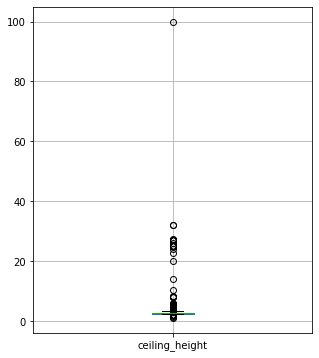

In [8]:
data.boxplot('ceiling_height', figsize=(5,6))

Есть аномальные значения, такие как высота потолка 100 метров. А также ряд значений с потолком выше 10 метров, что является либо ошибкой в данных, либо многоэтажной квартирой. Причины аномалий будем искать в дальнейшем, а сейчас заполним пропуски медианой. Это позволит избежать отклонений из-за слишком высоких или низких потолков, заполнит пропуски наиболее частотным значением.

In [9]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

***Изучим колонку сколько всего этажей в доме. Посмотрим уникальные значения.***

In [10]:
data['floors_total'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 33., 34., 35., 36., 37., 52., 60., nan])

В данном случае заполнить пропуски стоит уникальным, выбивающимся из остального ряда, значением. Поскольку адрес дома у нас в данных отсутствует, определить этажность по другим объявлениям или из третьих источников нельзя. Сама этажность является скорее категориальным значением, чем количественным, поэтому выбираю именно такой способ. Заполню пропуски значением -1.

In [11]:
data['floors_total'] = data['floors_total'].fillna(-1)

***Изучим колонку жилая площадь. Посмотрим, есть ли корреляция между общей площадью и жилой.***

In [12]:
data.total_area.corr(data.living_area)

0.9395373338721494

Корреляция очень высокая. В таком случае можно разделить данные по общей площади на несколько категорий, и заполнить пропуски в жилой площади медианой по жилой площади каждой категории.

In [13]:
#Делим общую площадь на категории
data['total_area_cat'] = pd.cut(data.total_area, [0, 30,60,100,150,250,400,np.inf])

#Заполняем пропуски медианой жилой площади по каждой категории
for i in data.total_area_cat.unique():
    data['living_area'] = data['living_area'].fillna(data[data['total_area_cat']==i]['living_area'].median())

***Изучим колонку аппартаменты***

In [14]:
data.is_apartment.unique()

array([nan, False, True], dtype=object)

In [15]:
data.is_apartment.value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Уникальные значения в колонке аппартаменты булево. Логично предположить, что везде, где пропуски - не аппартаменты, поскольку чаще всего продаются именно квартиры, и данное поле владельцы квартир часто пропускают. Заменю все пропуски на False

In [16]:
data.is_apartment = data.is_apartment.fillna(False)

***Изучим колонку площадь кухни. Посмотрим, есть ли корреляция между общей площадью и площадью кухни.***

In [17]:
data.total_area.corr(data.kitchen_area) 

0.6091211711198318

Корреляция средняя положительная. Считаю, что пропуски можно заполнить так же, как с жилой площадью, медианой по площади кухни каждой категории.

In [18]:
#Заполняем пропуски медианой площади кухни по каждой категории
for i in data.total_area_cat.unique():
    data['kitchen_area'] = data['kitchen_area'].fillna(data[data['total_area_cat']==i]['kitchen_area'].median())

***Изучим колонку балконы***

In [19]:
data.balcony.sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5., nan])

Заменим пропущенные значения на 0, поскольку скорее всего если количество балконов не указано, то их нет.

In [20]:
data.balcony = data.balcony.fillna(0)

***Удалим строки в колонке locality_name, в которых есть пропуски. Таких строк всего 49***

In [21]:
data.dropna(subset=['locality_name'], inplace = True)

***Колонки airports_nearest, city_centers_nearest, parks_nearest, ponds_nearest оставляем с пропусками, определить пропущенное расстояние не представляется возможным. Колонки parks_around3000 и ponds_around3000 также оставлю с пропусками.***

***Колонки parks_around3000 и ponds_around3000 имеют одинаковое количество пропусков, city_centers_nearest и airports_nearest тоже имеют близкое к ним значение пропусков. Проверю, в скольких объявлениях содержатся пропуски во всех четырех колонках одновременно.***

In [22]:
data.query(
    'ponds_around3000.isna() \
    and parks_around3000.isna() \
    and city_centers_nearest.isna() \
    and airports_nearest.isna()'
).ponds_around3000.isna().sum()

5510

Можно предположить, что квартиры в этих объявлениях находятся в новый районах, поэтому картографические данные оказались незаполнены.

***Колонку days_exposition оставлю с пропусками, скорее всего они связаны с тем, что объявления еще не закрыты. Так ли это, стоит уточнить у тех, кто предоставил выгрузку.***

In [23]:
#Количество пропусков после обработки
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5534
city_centers_nearest     5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
total_area_cat              0
dtype: int64

#### Изменение типов данных

In [24]:
#В колонке дата публикации меняем тип данных на дату
data.first_day_exposition = pd.to_datetime(data.first_day_exposition, format='%Y-%m-%dT%H:%M:%S')

In [25]:
#В колонке общее количество этажей, количество балконов меняем тип данных на int. Не бывает не целое число
data.floors_total = data.floors_total.astype('int')
data.balcony = data.balcony.astype('int')

#### Устранение дубликатов

In [26]:
#проверка на полные дубликаты строк
data.duplicated().sum()

0

In [27]:
#уникальные значения названий населенных пунктов
data.locality_name.sort_values().unique()

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

In [28]:
#количество уникальных значения названий населенных пунктов
data.locality_name.sort_values().nunique()

364

In [29]:
#создание новой колонки с названиями населенных пунктов после устранения неявных дубликатов
#приводим все к нижнему регистру, заменяем "ё" на "е"
data['locality_name_clear'] = data.locality_name.str.lower().replace('ё', 'е', regex=True)

In [30]:
#убираем типы населенных пунктов из названия
locality_list = ['городской поселок ', 'деревня ', 'поселок городского типа ', \
                  'коттеджный поселок ', 'поселок ', 'садовое товарищество ', 'село ']
data['locality_name_clear'] = data['locality_name_clear'].replace(locality_list, '', regex=True)

In [31]:
#уникальные названия после удаления дубликатов
data.locality_name_clear.sort_values().unique()

array(['агалатово', 'александровская', 'алексеевка', 'аннино', 'аро',
       'барышево', 'батово', 'бегуницы', 'белогорка', 'белоостров',
       'бокситогорск', 'большая вруда', 'большая ижора',
       'большая пустомержа', 'большие колпаны', 'большое рейзино',
       'большой сабск', 'бор', 'борисова грива', 'бугры', 'будогощь',
       'ваганово', 'важины', 'вартемяги', 'вахнова кара', 'виллози',
       'вознесенье', 'возрождение', 'войсковицы', 'войскорово',
       'володарское', 'волосово', 'волхов', 'всеволожск', 'выборг',
       'вырица', 'выскатка', 'высокоключевой', 'высоцк', 'гаврилово',
       'гарболово', 'гатчина', 'гладкое', 'глажево', 'глебычево',
       'глинка', 'гончарово', 'горбунки', 'гостилицы', 'громово',
       'дзержинского', 'дружная горка', 'дружноселье', 'дубровка',
       'елизаветино', 'ефимовский', 'жилгородок', 'жилпоселок', 'житково',
       'заводской', 'заклинье', 'заневка', 'запорожское', 'зеленогорск',
       'зимитицы', 'ивангород', 'извара', 'ильичев

In [32]:
#количество уникальных названий после удаления дубликатов
data.locality_name_clear.sort_values().nunique()

308

Удалось удалить 56 неявных дубликата, что составило 15% от всех названий.

#### Устранение аномалий и выбросов

Посмотрим на статистические данные по каждой колонке.

In [33]:
data.describe().round(2)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23650.00,2.365000e+04,23650.00,23650.00,23650.00,23650.00,23650.00,23650.00,23650.00,23650.00,18116.00,18139.00,18140.00,8064.00,18140.00,9085.00,20470.00
mean,9.86,6.541127e+06,60.33,2.07,2.72,10.63,37.17,5.89,11.05,0.59,28803.23,14197.86,0.61,490.83,0.77,518.06,180.75
std,5.68,1.089640e+07,35.66,1.08,0.99,6.62,23.06,4.88,5.80,0.96,12637.31,8606.83,0.80,342.55,0.94,277.84,219.78
min,0.00,1.219000e+04,12.00,0.00,1.00,-1.00,2.00,1.00,1.30,0.00,0.00,181.00,0.00,1.00,0.00,13.00,1.00
25%,6.00,3.400000e+06,40.00,1.00,2.60,5.00,19.00,2.00,7.30,0.00,18575.75,9241.00,0.00,288.00,0.00,293.00,45.00
50%,9.00,4.650000e+06,52.00,2.00,2.65,9.00,31.08,4.00,10.00,0.00,26756.50,13105.00,0.00,454.50,1.00,502.00,95.00
75%,14.00,6.799000e+06,69.70,3.00,2.70,16.00,46.00,8.00,13.50,1.00,37294.00,16293.00,1.00,612.00,1.00,730.00,231.00
max,50.00,7.630000e+08,900.00,19.00,100.00,60.00,409.70,33.00,112.00,5.00,84869.00,65968.00,3.00,3190.00,3.00,1344.00,1580.00


Выбросами можно считать все значения, в 1,5 раза превышающие разницу между третьим и первым квартилем. Однако не изучая данные подробнее, нельзя просто взять и удалить из датасета выбивающиеся значения. Посмотрим на каждую колонку на графиках.

<AxesSubplot:>

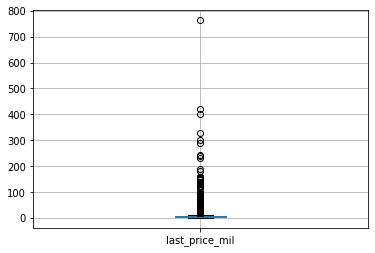

In [34]:
#перевод цены в миллионы и построение boxplot
data['last_price_mil'] = data.last_price/1000000
data.boxplot('last_price_mil')

Выбросов очень много. Посмотрим покрупнее

(0.0, 100.0)

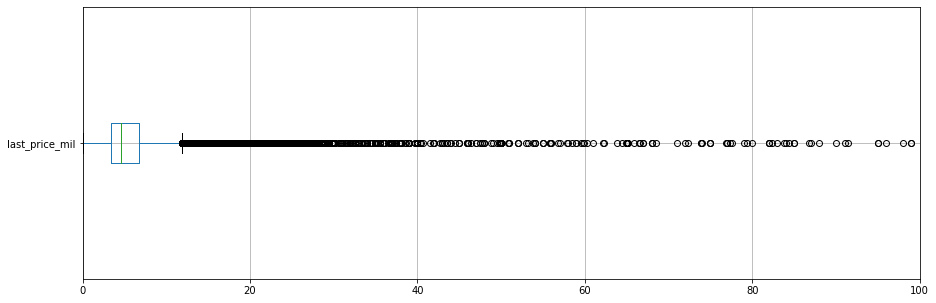

In [35]:
data.boxplot('last_price_mil',  figsize=(15,5), vert=False)
plt.xlim(0,100)

In [36]:
#5 самых дешевых квартир
data.last_price_mil.sort_values().head()

8793     0.01219
17456    0.43000
14911    0.43000
16274    0.44000
17676    0.45000
Name: last_price_mil, dtype: float64

In [37]:
#создаем новый датасет с очищенными данными
good_data = data.query('0.1<last_price_mil<40')
data.query('0.1>=last_price_mil or last_price_mil>=40').last_price_mil.count()

195

Оставим объявления дешевле 40 млн. и дороже 100 тыс., поскольку объявление за 12 тыс. явно с ошибочной ценой.  Удалили 195 объявления.

Теперь посмотрим на распределение комнат.

<AxesSubplot:>

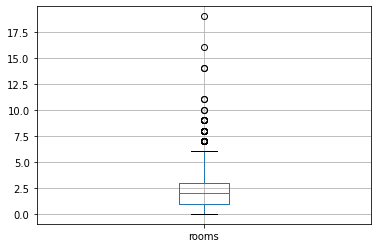

In [38]:
good_data.boxplot('rooms')

In [39]:
good_data = good_data.query('rooms<7')
data.query('rooms>=7').last_price_mil.count()

90

Оставим объявления, в которых меньше 7 комнат. Удалили 90 объявлений.

Теперь посмотрим на распределение общей площади.

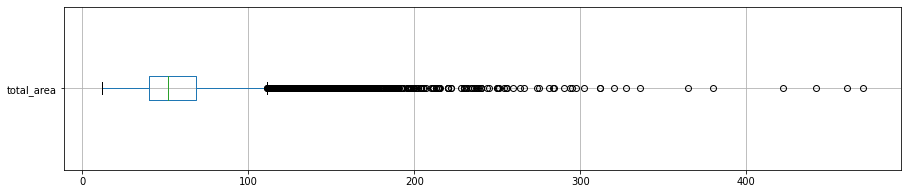

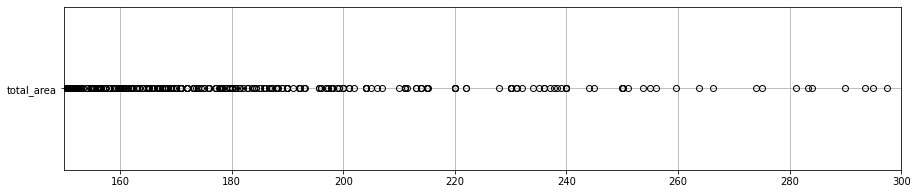

In [40]:
good_data.boxplot('total_area',figsize=(15,3), vert=False )
plt.show()

#ящик с усами укрупненно
good_data.boxplot('total_area',figsize=(15,3), vert=False )
plt.xlim(150,300)
plt.show()

In [41]:
good_data = good_data.query('total_area<200')
data.query('total_area>=200').last_price_mil.count()

231

Оставим объявления, в которых общая площадь меньше 200 метров. Удалили 231 объявление.

Далее устраним выбросы в жилой площади и в площади кухни, оставим 130 и 45 метров соответственно.

<AxesSubplot:>

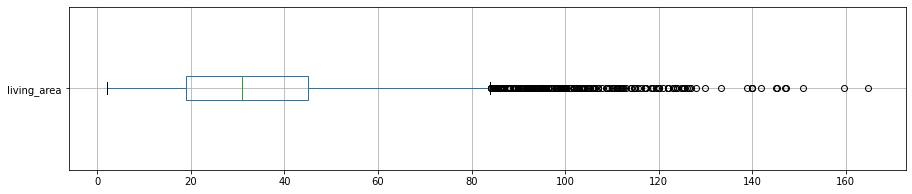

In [42]:
good_data.boxplot('living_area',  figsize=(15,3), vert=False)

In [43]:
good_data = good_data.query('living_area<130')
data.query('living_area>=130').last_price_mil.count()

180

<AxesSubplot:>

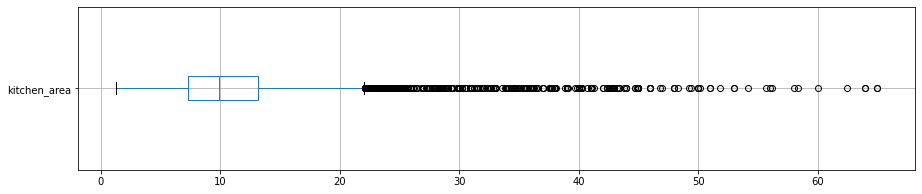

In [44]:
good_data.boxplot('kitchen_area',  figsize=(15,3), vert=False)

In [45]:
good_data = good_data.query('kitchen_area<45')
data.query('kitchen_area>=45').last_price_mil.count()

87

Изучим высоту потолков. Стандартная высота в Санкт-Петербурге и области составляет от 2,4 до 4,2 метров, может быть больше для старых домов и для многоэтажных квартир.

<AxesSubplot:>

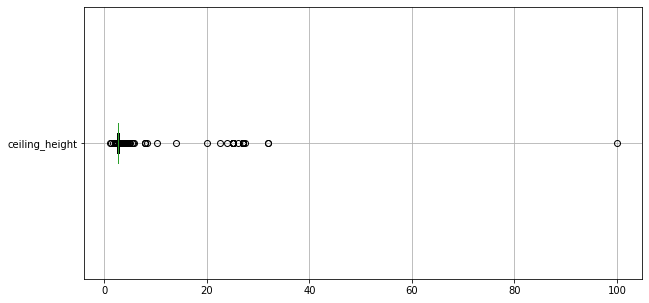

In [46]:
good_data.boxplot('ceiling_height',  figsize=(10,5), vert=False)

In [47]:
#удаляем выброс в 100 метров
good_data = good_data.query('ceiling_height<40')

In [48]:
#посмотрим уникальные значения высоты потолков
good_data.ceiling_height.sort_values().unique()

array([ 1.  ,  1.2 ,  1.75,  2.  ,  2.2 ,  2.25,  2.3 ,  2.34,  2.4 ,
        2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,  2.51,  2.52,  2.53,
        2.54,  2.55,  2.56,  2.57,  2.58,  2.59,  2.6 ,  2.61,  2.62,
        2.63,  2.64,  2.65,  2.66,  2.67,  2.68,  2.69,  2.7 ,  2.71,
        2.72,  2.73,  2.74,  2.75,  2.76,  2.77,  2.78,  2.79,  2.8 ,
        2.81,  2.82,  2.83,  2.84,  2.85,  2.86,  2.87,  2.88,  2.89,
        2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,  2.96,  2.97,  2.98,
        2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,  3.07,
        3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,  3.16,
        3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,  3.26,
        3.27,  3.28,  3.3 ,  3.31,  3.32,  3.33,  3.34,  3.35,  3.36,
        3.37,  3.38,  3.39,  3.4 ,  3.42,  3.44,  3.45,  3.46,  3.47,
        3.48,  3.49,  3.5 ,  3.51,  3.52,  3.53,  3.54,  3.55,  3.56,
        3.57,  3.58,  3.59,  3.6 ,  3.62,  3.63,  3.65,  3.66,  3.67,
        3.68,  3.7 ,

Высоту меньше 2,4 метра будем считать аномалией, заменим на медиану.

Высоту выше 6 метров и ниже 24 метров будем считать аномалией, заменим на медиану.

Заменяем значения от 24 метров и выше на эти же значения, уменьшенные в 10 раз. Скорее всего неверно занесли данные, ошиблись с разрядом

In [49]:
median_ceiling_height =good_data.ceiling_height.median() 
good_data.ceiling_height = good_data.ceiling_height.apply(
    lambda x: x/10 if x>=24 else (
        median_ceiling_height if (6<=x<24 or x<2.4) else x))

<AxesSubplot:>

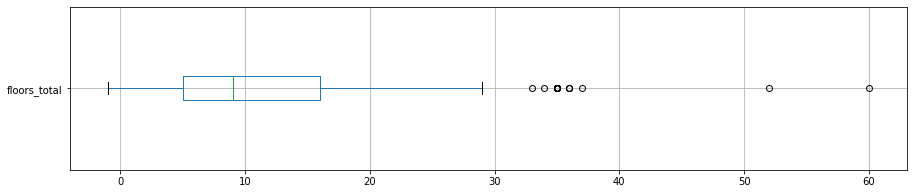

In [50]:
#Изучим этажность
good_data.boxplot('floors_total',  figsize=(15,3), vert=False)

In [51]:
#группировка выбросов по населенному пункту и этажности
good_data.query('floors_total>30').groupby(['locality_name_clear','floors_total']).floors_total.count()

locality_name_clear  floors_total
кронштадт            60               1
санкт-петербург      33               1
                     34               1
                     35              24
                     36               3
                     37               1
                     52               1
Name: floors_total, dtype: int64

In [52]:
#В Кронштадте нет домов выше 15 этажей, в Санкт-Петербурге самый высокий жилой дом - 37 этажей. Удаляем выбросы
good_data = good_data.query('floors_total<38')

Посмотрим на количество балконов, посчитаем, где их 3 и более. Квартиры с таким количеством балконов выглядят неправдоподобно, но на исследование не влияют, поэтому ничего не будем делать с этими объявлениями.

<AxesSubplot:>

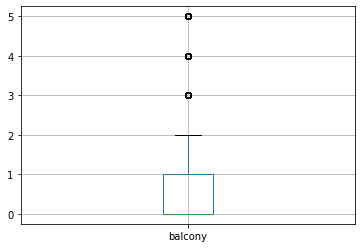

In [53]:
good_data.boxplot('balcony')

In [54]:
good_data.query('balcony>=3').balcony.count()

550

**Посмотрим, как выглядят данные после очистки**

In [55]:
print('До обработки',data.shape)
print('После обработки', good_data.shape)

До обработки (23650, 25)
После обработки (23243, 25)


In [56]:
#количество оставшихся после удаления данных, %
round(good_data.shape[0]/data.shape[0], 2)

0.98

### Посчитайте и добавьте в таблицу новые столбцы

In [57]:
#цена одного квадратного метра
good_data['price_per_metr'] = (good_data.last_price/good_data.total_area).round(0)

In [58]:
#день недели публикации объявления (0 — понедельник, 1 — вторник и так далее)
good_data['day_of_week_exposition'] = good_data.first_day_exposition.dt.dayofweek

In [59]:
#месяц публикации объявления
good_data['month_exposition'] = good_data.first_day_exposition.dt.month

In [60]:
#год публикации объявления
good_data['year_exposition'] = good_data.first_day_exposition.dt.year

In [61]:
#Функция тип этажа квартиры (значения — «первый», «последний», «другой»)
def categorize_floor(row):
    try:
        if row.floor==1:
            return 'первый'
        elif row.floor == row.floors_total:
            return 'последний'
        else:
            return 'другой'
    except:
        pass

In [62]:
good_data['floor_cat'] = good_data.apply(categorize_floor, axis=1)

In [63]:
#расстояние до центра города в километрах (переведите из м в км и округлите до целых значений)
good_data['city_centers_nearest_km'] = (good_data.city_centers_nearest/1000).round(0)

### Проведите исследовательский анализ данных

#### Изучите параметры объектов

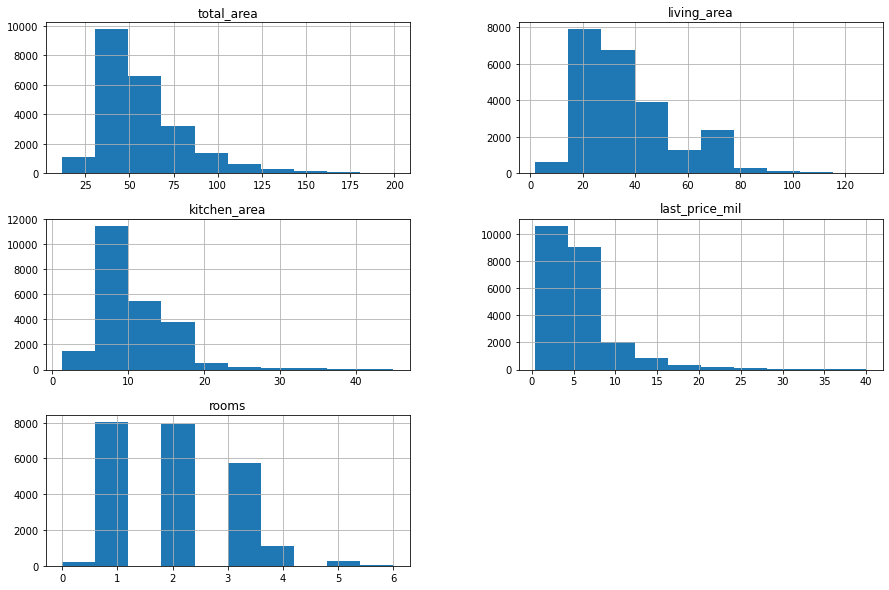

In [64]:
good_data.hist(['total_area', 'living_area', 'kitchen_area', 'last_price_mil', 'rooms'], figsize=(15,10));

По площади и цене видим стандартное распределение.

Общая площадь 30-50 метров, жилая 17-28 метров, площадь кухни 6-11 метров. Продаются в основном квартиры с 1 и 2 комнатами, что коррелирует с площадями.

Цена в основном до 4,7 млн.

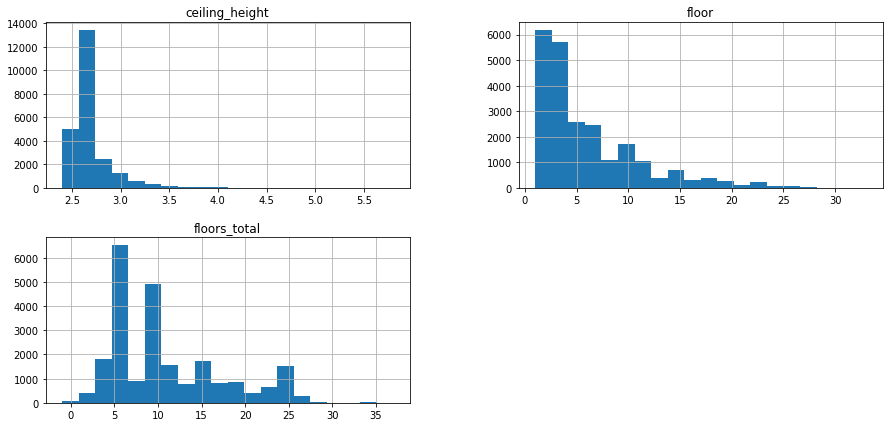

In [65]:
good_data.hist(['ceiling_height', 'floor', 'floors_total'], figsize=(15,7), bins=20);

Высота потолков в основном между 2,6 и 2,7 метров.

Квартир больше всего покупают на 1-4 этажах. При этом самая популярная этажность домов - 5 и 9, скорее всего это дома старых годов постройки, времен СССР.

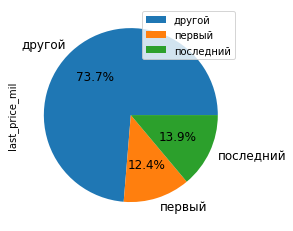

In [66]:
#распределение квартир по категориям этажа. Нагляднее построить круговую диаграмму, а не гистограмму
floor_cat_pivot = good_data.pivot_table(index = 'floor_cat', values= 'last_price_mil',aggfunc='count')
floor_cat_pivot.plot(kind='pie', y='last_price_mil', autopct=lambda p:f'{p:.1f}%', fontsize=12);

Квартир на первом и на последнем этажах продается примерно одинаково, 12-14%, основную долю составляют квартиры на других этажах.

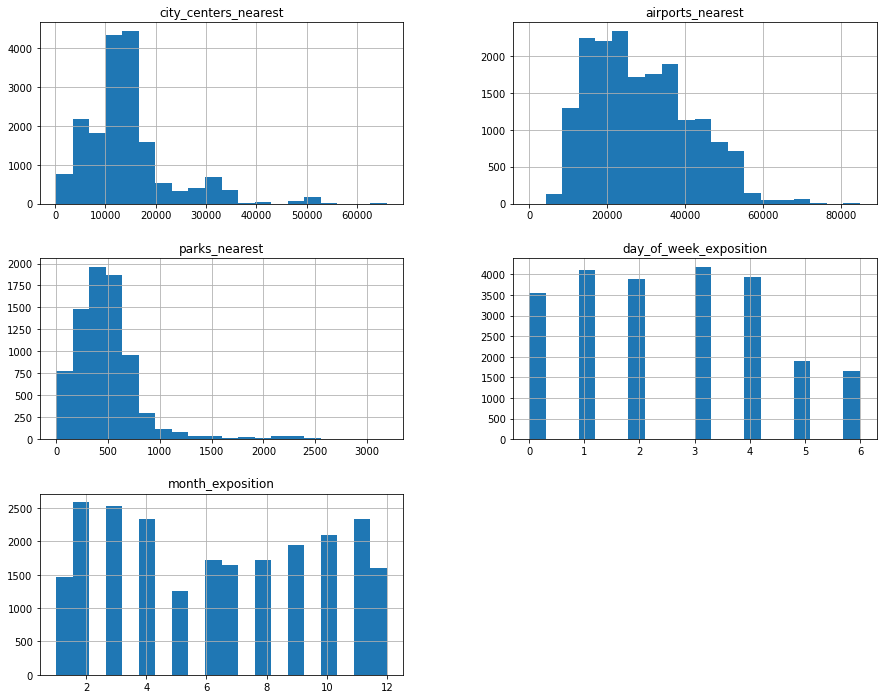

In [67]:
good_data.hist(
    ['city_centers_nearest', 'airports_nearest', 'parks_nearest', 'day_of_week_exposition', 'month_exposition'], 
    figsize=(15,12), bins=20);

По расстоянию до центра города, до аэропорта и до ближайшего парка распределение нормальное.

Квартиры продаются в основном на насстоянии 10-16 км от центра, 15-25 км от аэропорта и в 300-600 метрах от парка.

В субботу и в воскресенье публикуется в 2 раза меньше объявлений, чем в будние дни. Возможно дело в том, что в выходные продавцы занимаются личными делами и не готовы отвечать на звонки и организовывать показы.

Что касается месяцев года, то спад виден в январе (новый год), в мае (много праздников), декабре (новый год), а также летом (отпуска, дача).

#### Изучите как быстро продавались квартиры

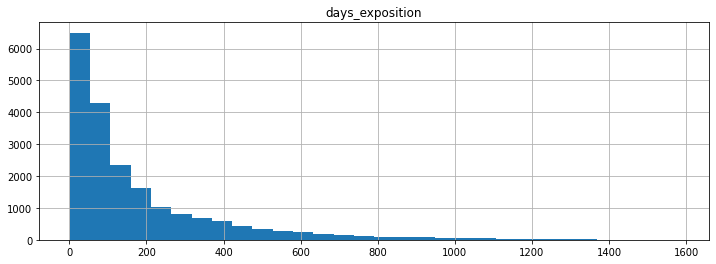

In [68]:
good_data.hist('days_exposition', figsize=(12,4), bins=30);

In [69]:
good_data.days_exposition.describe()

count    20162.000000
mean       178.809791
std        217.447165
min          1.000000
25%         45.000000
50%         94.000000
75%        228.000000
max       1580.000000
Name: days_exposition, dtype: float64

Объявление в основном размещено около 100 дней. 
Имеется большое число квартир, проданных в первые несколько дней после публикации. Но также есть и варианты, которые продавались месяцами, если не годами.

Медиана составляет 94 дня, а среднее значение смещено сильно выше, равно 179 дням. Это связано с тем, что есть ряд объявлений, которые не закрываются годами (возможно, забыли закрыть, или цена слишком высокая, никто не покупает).

Таким образом, обычно продажа занимает 3 месяца, быстрыми можно считать продажи менее 45 дней (первый квартиль), а необычно долгими свыше 228 дней (третий квартиль).

#### Какие факторы больше всего влияют на общую (полную) стоимость объекта

Выделим факторы, взаимосвязь которых мы будем изучать, в отдельную таблицу

In [70]:
price_corr_factors = (good_data[['last_price_mil','total_area', 'living_area', 'kitchen_area', 'rooms',
                                 'day_of_week_exposition', 'month_exposition', 
                                 'year_exposition','floor_cat']])

In [71]:
#Найдем коэффициент корреляции для всех столбцов, кроме типа этажа, дня, месяца, года
price_corr_factors[['last_price_mil','total_area', 'living_area', 'kitchen_area', 'rooms']].corr()

,last_price_mil,total_area,living_area,kitchen_area,rooms
last_price_mil,1.000000,0.770247,0.536519,0.509436,0.473442
total_area,0.770247,1.000000,0.760136,0.473957,0.789938
living_area,0.536519,0.760136,1.000000,0.364610,0.715912
kitchen_area,0.509436,0.473957,0.364610,1.000000,0.132648
rooms,0.473442,0.789938,0.715912,0.132648,1.000000


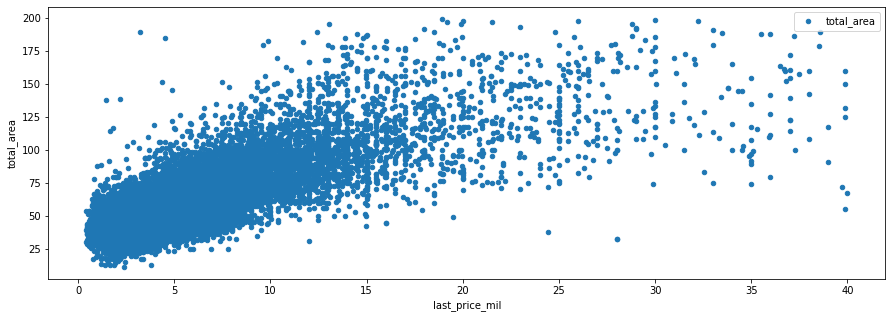

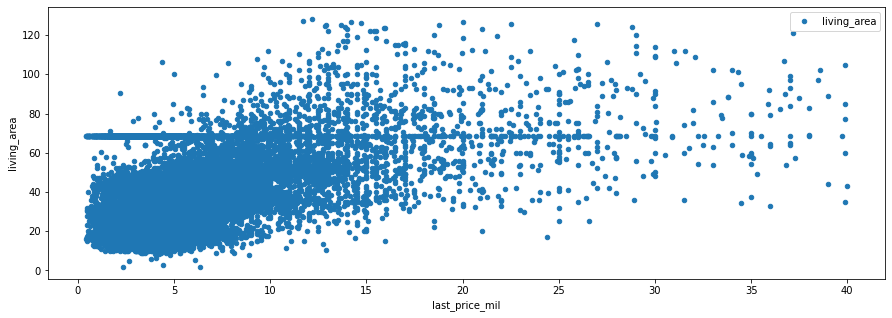

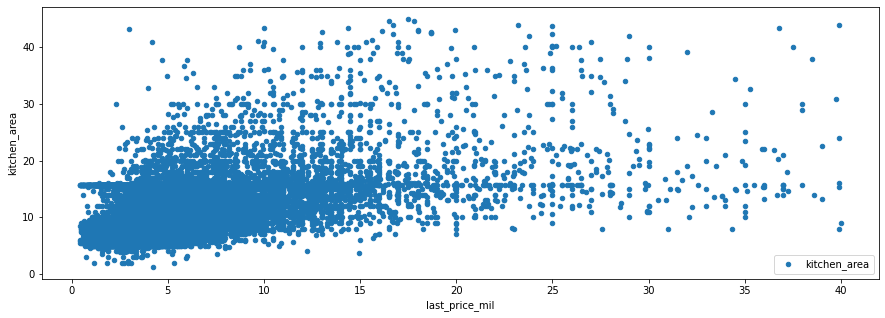

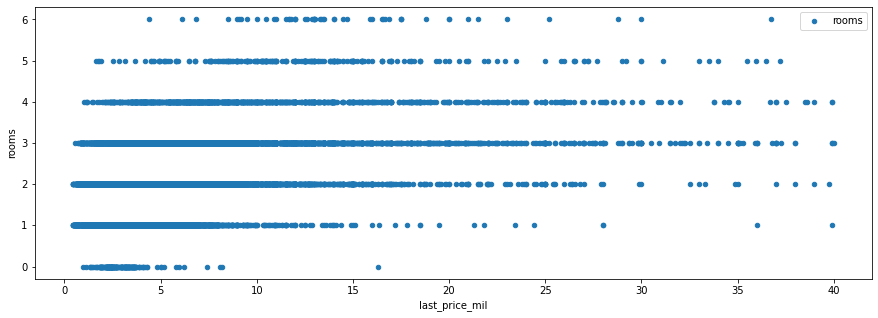

In [72]:
#построим диаграммы рассеивания попарно цены с остальными параметрами
list_corr=['total_area', 'living_area', 'kitchen_area', 'rooms']
for i, el in enumerate(list_corr):
    price_corr_factors.plot(kind='scatter',x = 'last_price_mil', y = str(el), label=el, figsize = (15,5))
    plt.show()

Взаимосвязь цены
- с общей площадью ярко выражена, особенно на цене до 15 млн., корреляция прямая, дороже корреляция практически отсутствует. В дорогих объектах помимо метража важны и другие параметры.
- с жилой площадью кореляция также прямая, хотя выражена меньше, после стоимости в 15 млн.идет рассеивание.
- с площадью кухни взаимосвязь еще меньше, в основном все предложения с кухнями от 6 до 15 метров, причем при увеличении цены площадь кухни практически не меняется.
- с количеством комнат корреляция неявная, думаю из-за того, что комнаты могут быть разной площади. Явно видно, что студии самые дешевые, однокомнатые квартиры в основном не дороже 15 млн., а вот разницы по цене между 3, 4, 5 комнатными практически нет.

In [73]:
#функция корреляция цены от других параметром
def corr_cat(category):
    price_corr=good_data.pivot_table(index=category, values='last_price_mil', aggfunc=['median', 'mean']) 
    price_corr.columns=['Медиана', 'Среднее']
    price_corr.plot(grid=True, style='o-', figsize=(10, 5));

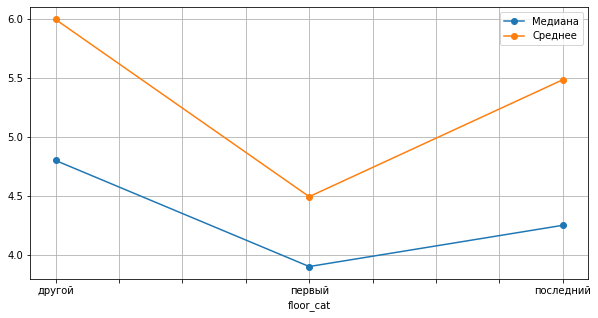

In [74]:
#сводная таблица категория этажа - медианная цена квартиры. B график по ней
corr_cat('floor_cat')

Связь цены и этажа ярко выражена. Первый этаж стоит дешевле остальных, последний  немного дороже, другие этажи самые дорогие.

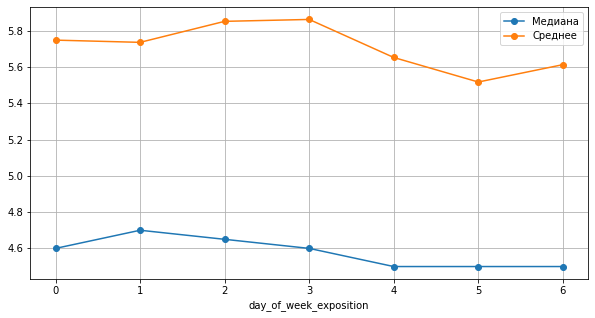

In [75]:
corr_cat('day_of_week_exposition')

День недели не сильно влияет на цену квартиры, колебания минимальны, особенно по медиане (более дорогие квартиры выкладывают во вторник). Хотя по средней видна просадка в субботу, похоже в этот день выкладывается небольшое количество дешевых объявлений, что не влияет на медиану, но сказывается на средней.

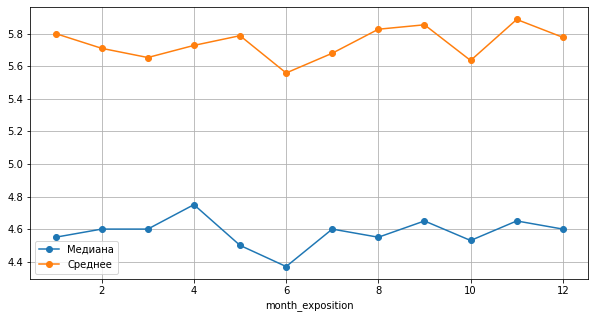

In [76]:
#сводная таблица месяц - медианная цена квартиры. B график по ней
corr_cat('month_exposition')

Месяц размещения объявления практически не сказывается на цене, колебания в пределах 400 тыс., хотя в апреле и сентябре квартиры дороже, а в июне и октябре видна просадка.

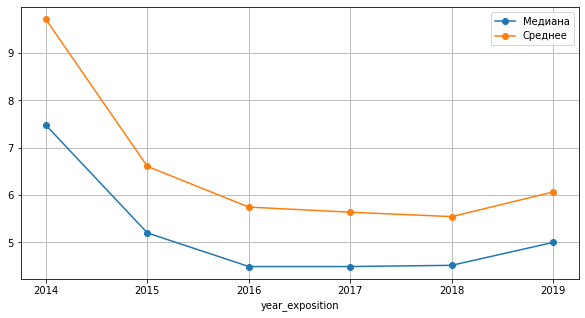

In [77]:
#сводная таблица год - медианная цена квартиры. B график по ней
corr_cat('year_exposition')

Самые высокие цены были в 2014 году, потом на рынке наметился спад, что объясняется экономичечским кризисом, падением цен на нефть, падением рубля. В 2019 наметилась тенденция к росту, которая, как мы знаем, продолжалась вплоть до 2022 года.

**Вывод: больше всего влияет на общую (полную) стоимость объекта общая площадь, что подтверждается графиком и коэффициентом корреляции 0,77, а также этаж. Год тоже влияет, но его влияение мы видим постфактум, и оно отражает общую экономическую ситуацию**

#### Анализ цены одного квадратного метра

In [78]:
#Расчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
avr_price_city = good_data.pivot_table(index='locality_name_clear',values='price_per_metr', aggfunc=['mean', 'count'])
avr_price_city.columns=['mean_price_per_metr', 'count']

city_top10 = avr_price_city.sort_values('count', ascending=False).head(10).sort_values('mean_price_per_metr', ascending=False)
city_top10

,mean_price_per_metr,count
locality_name_clear,,
санкт-петербург,111476.227193,15335
пушкин,102919.626039,361
кудрово,95324.957627,472
парголово,90332.236196,326
мурино,86087.263158,589
шушары,78677.379545,440
колпино,75333.287834,337
гатчина,68746.110749,307
всеволожск,68654.474874,398


In [79]:
#Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра
city_min = city_top10.query('mean_price_per_metr == mean_price_per_metr.min()').index.to_list()[0]
city_max= city_top10.query('mean_price_per_metr == mean_price_per_metr.max()').index.to_list()[0]
print(f'Самая высокая стоимость квадратного метра в городе {city_max}')
print(f'Самая низкая стоимость квадратного метра в городе {city_min}')

Самая высокая стоимость квадратного метра в городе санкт-петербург
Самая низкая стоимость квадратного метра в городе выборг


Больше всего объявлений в Санкт-Петербурге, что ожидаемо, поскольку он является центром области. Цена за метр там 111,5 тыс руб., на втором месте по цене г. Пушкин, 103 тыс. руб., на последней Выборг, 58 тыс. руб.

#### Анализ средней цены каждого километра в Санкт-Петербурге

In [80]:
#средняя цена каждого километра в Санкт-Петербурге
avr_price_km = good_data.query('locality_name_clear == "санкт-петербург"') \
    .pivot_table(index='city_centers_nearest_km',values='last_price_mil').round(2)
avr_price_km.columns=['mean_price_km']
avr_price_km

,mean_price_km
city_centers_nearest_km,
0.0,14.93
1.0,11.70
2.0,11.07
3.0,9.60
4.0,10.50
5.0,10.93
6.0,10.18
7.0,10.25
8.0,8.83


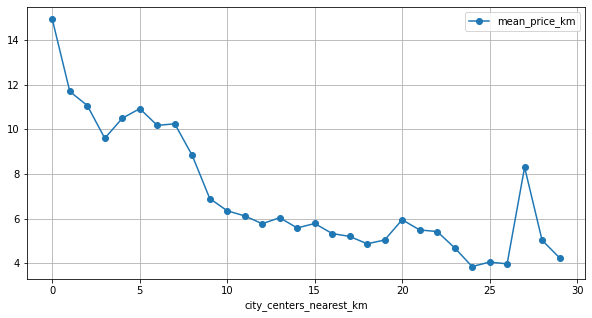

In [81]:
avr_price_km.plot(grid=True, style='o-', figsize=(10, 5));

In [82]:
avr_price_km.reset_index().corr()

,city_centers_nearest_km,mean_price_km
city_centers_nearest_km,1.000000,-0.830579
mean_price_km,-0.830579,1.000000


Стоимость объектов зависит от расстояния до центра города. Коэффициент корреляции отрицательный, -0,83, чем дальше от центра, тем ниже цена. Есть всплеск на 5 километрах, скорее всего связан с квартирами на Крестовском острове, это дорогой район Санкт-Петербурга. На 27 км. наблюдается высокий пик.

In [83]:
#посмотрим объявления на 27 км
price_27km = good_data.query('city_centers_nearest_km==27')
price_27km['last_price_mil'].describe()

count    103.000000
mean       5.722588
std        4.413323
min        1.980000
25%        3.375000
50%        4.200000
75%        6.150000
max       29.500000
Name: last_price_mil, dtype: float64

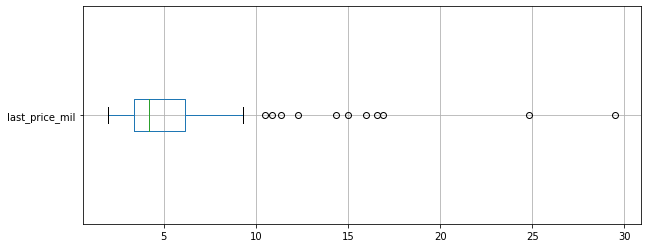

In [84]:
price_27km.boxplot('last_price_mil',  figsize=(10,4), vert=False);

Медиана составляет 4,2 млн, что соответствует остальным распределениям цены на километр, однако есть несколько выбросов от 10 до 30 млн., которые сдвинули среднее вверх и образовади аномальный пик.

In [85]:
price_27km.query('last_price_mil>10')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,total_area_cat,locality_name_clear,last_price_mil,price_per_metr,day_of_week_exposition,month_exposition,year_exposition,floor_cat,city_centers_nearest_km
140,8,16912000.0,105.70,2016-12-09,2,2.70,3,48.40,1,False,False,False,15.4,0,Пушкин,14352.0,26506.0,3.0,366.0,3.0,179.0,390.0,"(100.0, 150.0]",пушкин,16.912,160000.0,4,12,2016,первый,27.0
748,13,14350000.0,74.00,2017-11-28,2,3.13,5,30.00,3,False,False,False,25.0,0,Санкт-Петербург,23888.0,27313.0,1.0,1496.0,0.0,NaN,128.0,"(60.0, 100.0]",санкт-петербург,14.350,193919.0,1,11,2017,другой,27.0
2414,20,29500000.0,115.00,2017-07-21,3,3.00,2,69.75,2,False,False,False,19.2,4,Пушкин,14456.0,26609.0,3.0,229.0,3.0,172.0,328.0,"(100.0, 150.0]",пушкин,29.500,256522.0,4,7,2017,последний,27.0
2776,8,10500000.0,105.00,2017-12-06,4,3.12,3,76.30,1,False,False,False,6.3,0,Пушкин,14880.0,27034.0,1.0,169.0,0.0,NaN,NaN,"(100.0, 150.0]",пушкин,10.500,100000.0,2,12,2017,первый,27.0
2948,23,11350000.0,75.00,2017-08-15,3,3.50,2,52.70,2,False,False,False,8.7,4,Пушкин,15337.0,27490.0,3.0,216.0,3.0,153.0,207.0,"(60.0, 100.0]",пушкин,11.350,151333.0,1,8,2017,последний,27.0
4400,4,12300000.0,78.65,2017-09-09,3,2.65,5,48.00,1,False,False,False,11.0,0,Пушкин,14567.0,26720.0,2.0,403.0,0.0,NaN,4.0,"(60.0, 100.0]",пушкин,12.300,156389.0,5,9,2017,первый,27.0
7996,17,16600000.0,106.00,2017-12-02,4,3.20,3,50.00,3,False,False,False,30.0,0,Пушкин,14822.0,26976.0,1.0,254.0,0.0,NaN,NaN,"(100.0, 150.0]",пушкин,16.600,156604.0,5,12,2017,последний,27.0
12466,11,15000000.0,89.60,2017-01-31,3,2.65,3,57.00,3,False,False,False,13.5,0,Пушкин,15065.0,27218.0,3.0,317.0,3.0,509.0,357.0,"(60.0, 100.0]",пушкин,15.000,167411.0,1,1,2017,последний,27.0
15578,20,16000000.0,101.90,2018-01-08,2,2.87,4,48.10,1,False,False,False,26.9,0,Пушкин,15201.0,27355.0,2.0,273.0,3.0,368.0,NaN,"(100.0, 150.0]",пушкин,16.000,157017.0,0,1,2018,первый,27.0
18386,15,24800000.0,190.00,2014-12-10,4,2.62,4,104.10,3,False,False,False,30.0,0,Пушкин,15072.0,27226.0,1.0,114.0,0.0,NaN,NaN,"(150.0, 250.0]",пушкин,24.800,130526.0,2,12,2014,другой,27.0


Почти все эти объявления расположены в Пушкине, возможно это какой-то элитный ЖК.

### Общий вывод

По итогам исследования данных о продажах квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет удалось установить следующее:

***Срок продажи квартиры***
- Половина объявлений закрывается за 3 месяца. 
- При этом 25% продаются в первые 1,5 месяца.
- Среднее время продажи составляет около полугода. Это связано с тем, что есть ряд объявлений, которые не закрываются годами (возможно, забыли закрыть, или цена слишком высокая, никто не покупает).

***Факторы, влияющие на стоимость***
- Связь цены с общей площадью наиболее ярко выражена, особенно на цене до 15 млн., чем выше площадь, тем дороже квартира.
- Однако дорогих объектах (более 15 млн. руб.) помимо метража важны и другие параметры.
- С жилой площадью  и площадью кухни кореляция также прямая, хотя выражена меньше.
- Квартиры на первом этаже самые дешевые, далее идут квартиры на последнем этаже, на других этажах самые дорогие.
- Сильное влияние на цену оказывает общая экономическая ситуация, которая меняется от года к году.

***Стоимость квадратного метра в топ-10 населённых пунктов***
- Дороже всего квадратный метр в Санкт-Петербурге - 111 тыс. руб
- Дешевле всего квадратный метр в Выборге - 58 тыс. руб.

***Стоимость средней цены каждого километра в Санкт-Петербурге***
- Чем ближе к центру города, тем дороже.
- Есть всплеск на 5 километрах на Крестовском острове (дорогой район).
- На 27 километре несколько аномально дорогих квартир в Пушкине.

***Таким образом больше всего на стоимость влияет общий метраж, этаж квартиры и близость к центру города***